<a href="https://colab.research.google.com/github/egorssed/Galaxy_modelling_VAE/blob/main/Loss_functions_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import matplotlib as mpl
import keras.backend as K
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
Folder='/content/drive/My Drive/TP4b/'

import sys
import os
sys.path.append(Folder+'/Modules')

#Utility modules
import Variational_autoencoder as VAE
import VAE_analysis as Analysis
import Image_Fits_Stats
import Visual_analysis
import Dataset_overview_filtering as overview

VAE.image_size=64
VAE.batch_size = 32
VAE.latent_dim = 64
VAE.start_lr = 1e-6

Mounted at /content/drive


### Prepare the data

In [2]:
from sklearn.model_selection import train_test_split


#We normalize the data to [0,1]

#Read the images and the features from the google drive
galaxy_images=np.load(Folder+'Data/Radial_cut=0.05/Images_MAD_Filtered.npy')
df=pd.read_csv(Folder+'Data/Radial_cut=0.05/Labels_MAD_Filtered.csv',index_col=0)


#Leave the number of images multiple of the batch_size
Size_of_dataset=len(galaxy_images[:-(len(galaxy_images)%VAE.batch_size)])
Number_of_batches=Size_of_dataset//VAE.batch_size
df=df.iloc[:Size_of_dataset]
galaxy_images=galaxy_images[:Size_of_dataset]

#Bring images to a proper tensorial form
gal_dataset_images=np.reshape(VAE.normalize_image(copy.deepcopy(galaxy_images)), 
                              (len(galaxy_images), galaxy_images.shape[1], galaxy_images.shape[2], 1)).astype('float32')
df['Noise_sigma']/=df['max_I']
#Separate the features we are eager to predict in the latent space
Features=['max_I','Noise_sigma']

#Extract test dataset
x_train,x_test,y_train,y_test= train_test_split(gal_dataset_images, df[Features].astype('float32'), test_size=round(0.05*Number_of_batches)*VAE.batch_size,random_state=42)
#Extract train and validation datasets
x_train, x_val , y_train, y_val= train_test_split(x_train, y_train, test_size=round(0.05*Number_of_batches)*VAE.batch_size,random_state=42)
#All the sets have number of galaxies which is a multiple of the batch size (32)
#The random_state is fixed so the split is reproducible yet random

Label the images such that we can pass additional information to the reconstruction loss functions

In [3]:
Features_number=len(Features)
Features_means=df[Features].mean(axis=0)
Features_stds=df[Features].std(axis=0)

def make_labeled_images(x,labels):
  res=np.zeros((len(x),x.shape[1]+1,x.shape[2],1))
  res[:,:-1,:,:]=x
  res[:,-1,:Features_number,0]=labels
  return res.astype('float32')

x_train_labeled=make_labeled_images(x_train,y_train)
x_test_labeled=make_labeled_images(x_test,y_test)
x_val_labeled=make_labeled_images(x_val,y_val)
galaxies_labeled=make_labeled_images(gal_dataset_images,df[Features])

In [4]:
#Data to estimate model's quality

COSMOS_indices_to_compare=np.zeros(8,dtype=int)
COSMOS_indices_to_compare=[33671, 25576, 45805, 31577, 41707, 19844, 13628,  8624]
images_to_compare_indices=df[np.isin(df.COSMOS_index,COSMOS_indices_to_compare)].index
imgs=np.zeros((32,64,64,1))
imgs[:8] = gal_dataset_images[images_to_compare_indices]
labels_to_compare=np.ones((32,2))
labels_to_compare[:8]=df.iloc[images_to_compare_indices][['max_I','Noise_sigma']]
n_compare = 8

# Load intermediate model

In [43]:
beta_vae=1e-2
activation='softplus'
loss_type='mse'

models,model_loss_function,reconstruction_loss_function,regularization_loss_function=\
  VAE.get_VAE(activation,loss_type,beta_vae=beta_vae)

Checkpoint_to_load=130
Checkpoint_name='Models/MAE+Softplus/beta_vae=1e-2/'
Checkpoints_Folder=Folder+Checkpoint_name

models['vae'].load_weights(Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load))

#z_means=models['z_meaner'].predict(gal_dataset_images)
#z_log_vars=models['z_log_varer'].predict(gal_dataset_images)
#decoded=models['vae'].predict(gal_dataset_images)
#std_of_mu=z_means.std(axis=0)
#mean_of_var=(np.exp(z_log_vars/2)).mean(axis=0)
#ratio=std_of_mu/mean_of_var

# Reconstruction loss

## Galaxy for gradients estimation

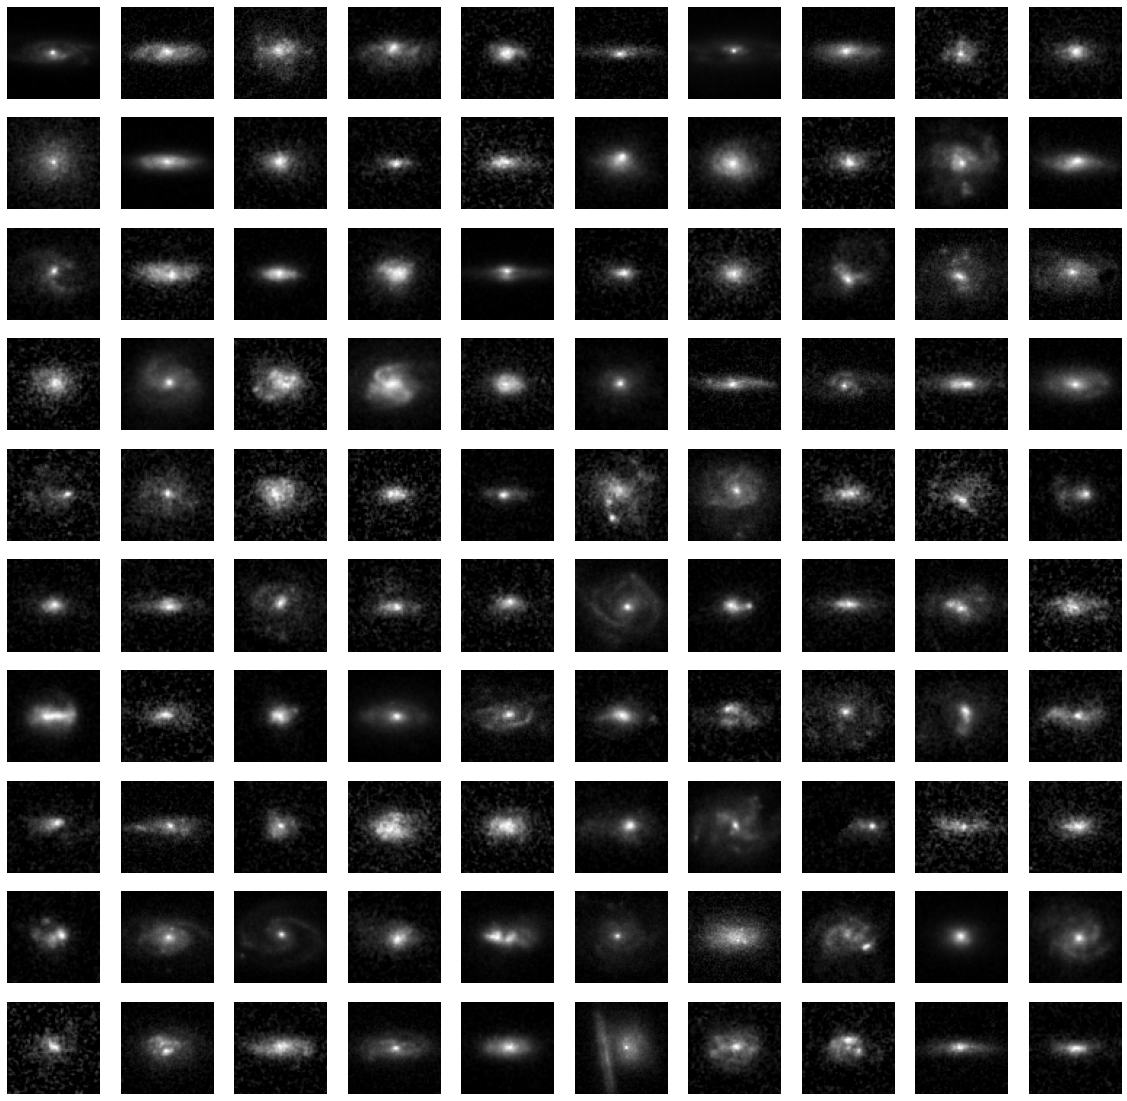

In [44]:
overview.Show_100(x_test[:,:,:,0],y_test.reset_index().iloc[300:],cmap='gray')

In [7]:
#grad_estim_galaxy=x_test[382:414]
#grad_estim_galaxy_pred=models['vae'].predict(grad_estim_galaxy)
#grad_estim_labels=y_test[382:414]

In [301]:
grad_estim_galaxy=imgs
grad_estim_galaxy_pred=models['vae'].predict(grad_estim_galaxy).astype('double')
grad_estim_labels=labels_to_compare

## Gradients

In [392]:
def MAE_from_Deconv(y,Deconv,labels=None):
  x=K.softplus(Deconv)
  return K.sum(K.abs(y-x),axis=[1,2,3])

def MSE_from_Deconv(y,Deconv,labels=None):
  x=K.softplus(Deconv)
  return K.sum(K.square(y-x),axis=-1)



def BCE_from_logits(y,logit,labels=None):
  x=tf.sigmoid(logit)
  return K.sum(K.binary_crossentropy(y,x),axis=-1)

def SSIM_loss(y,x,labels=None):
  return tf.image.ssim(y,x,max_val=1,filter_size=8)

def SSIM_from_Deconv(y,Deconv,labels=None):
  x=K.softplus(Deconv)
  return tf.image.ssim(y,x,max_val=1,filter_size=8)


power_factors=np.array([0.0448, 0.2856, 0.3001, 0.2363])
power_factors/=power_factors.sum()

def MS_SSIM_loss(y,x,labels=None):
  return tf.image.ssim_multiscale(y,x,max_val=1,filter_size=8,power_factors=power_factors)


def MS_SSIM_from_Deconv(y,Deconv,labels=None):
  x=K.softplus(Deconv)
  return 1-tf.image.ssim_multiscale(y,x,max_val=1,filter_size=8,power_factors=power_factors)

In [393]:
grad_estim_galaxy_pred[grad_estim_galaxy_pred>0.999]=0.999
grad_estim_galaxy_pred[grad_estim_galaxy_pred<0.001]=0.001
logit_grad_estim_galaxy_pred=np.log(grad_estim_galaxy_pred/(1-grad_estim_galaxy_pred))
logSoft_grad_estim_galaxy_pred=np.log(np.exp(grad_estim_galaxy_pred)-1)

In [389]:
def gauss_kernel(l=64, sig=8.):
    """\
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = tf.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = tf.meshgrid(ax, ax)

    kernel = tf.math.exp(-0.5 * (tf.square(xx) + tf.square(yy)) / tf.square(sig))

    return kernel / K.sum(kernel)

In [395]:
BCE_logit_grads=Analysis.calculate_gradient(grad_estim_galaxy,logit_grad_estim_galaxy_pred,BCE_from_logits)

#SSIM_grads=Analysis.calculate_gradient(grad_estim_galaxy,grad_estim_galaxy_pred,SSIM_loss)
SSIM_grads=Analysis.calculate_gradient(grad_estim_galaxy,logSoft_grad_estim_galaxy_pred,SSIM_from_Deconv)

#MS_SSIM_grads=Analysis.calculate_gradient(grad_estim_galaxy,grad_estim_galaxy_pred,MS_SSIM_loss)
MS_SSIM_grads=Analysis.calculate_gradient(grad_estim_galaxy,logSoft_grad_estim_galaxy_pred,MS_SSIM_from_Deconv)

#MAE_grads=Analysis.calculate_gradient(grad_estim_galaxy,grad_estim_galaxy_pred,VAE.get_reconstruction_loss('mae'))
MAE_grads=Analysis.calculate_gradient(grad_estim_galaxy,logSoft_grad_estim_galaxy_pred,MAE_from_Deconv)

#MSE_grads=Analysis.calculate_gradient(grad_estim_galaxy,grad_estim_galaxy_pred,VAE.get_reconstruction_loss('mse'))
MSE_grads=Analysis.calculate_gradient(grad_estim_galaxy,logSoft_grad_estim_galaxy_pred,MSE_from_Deconv)

alpha=0.5
combined_grads=alpha*SSIM_grads+(1-alpha)*MAE_grads*gauss_kernel(sig=8.)
#chi_sq_grads=Analysis.calculate_gradient(grad_estim_galaxy,grad_estim_galaxy_pred,VAE.get_reconstruction_loss('chi_sq'),labels=grad_estim_labels)

In [396]:
K.sum(Gaussian_kernel)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [397]:
(SSIM_grads)[1].max()

0.0027230062647420365

In [400]:
K.eval(MAE_grads*gauss_kernel(sig=8.)).max()

0.0015408461

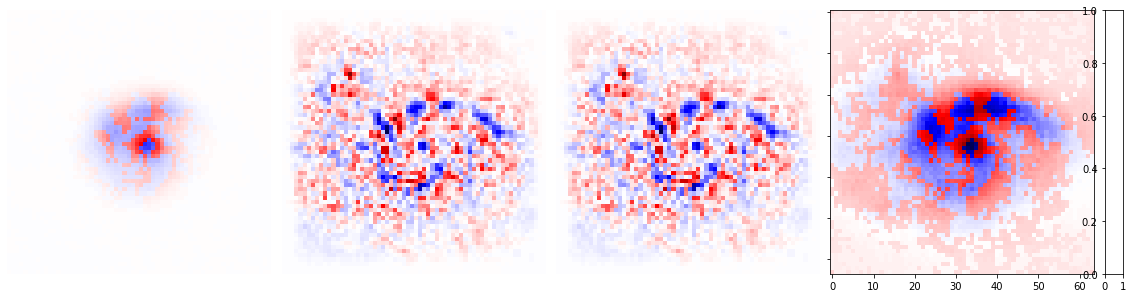

In [380]:
from mpl_toolkits.axes_grid1 import ImageGrid

im_titles=['Ground truth "Y" ','Prediction "X" ',r'$\mathrm{\partial MAE \slash \partial L}$',r'$\mathrm{\partial MSE \slash \partial L}$',\
           r'$\mathrm{\partial BCE \slash \partial L}$',\
           r'$\mathrm{\partial SSIM \slash \partial L}$',\
           r'$\mathrm{\partial MS\_SSIM \slash \partial L}$']

# Set up figure and image grid
fig = plt.figure(figsize=(20,20))

ax = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

vmin=combined_grads[1,:,:,0].min()
vmax=combined_grads[1,:,:,0].max()
norm=mpl.colors.TwoSlopeNorm(0,vmin,vmax)
ax[0].imshow((1-alpha)*MAE_grads[1,:,:,0]*gauss_kernel(sig=8),cmap='seismic',norm=norm)
ax[1].imshow(combined_grads[1,:,:,0],cmap='seismic',norm=norm)
ax[2].imshow(alpha*SSIM_grads[1,:,:,0],cmap='seismic',norm=norm)
ax[3].imshow(MAE_grads[1,:,:,0],cmap='seismic')

for i in range(3):
  #ax[i].set_title(im_titles[i],fontsize=15)
  ax[i].axis('off')


#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

In [309]:
def norm(tensor):
    image=tensor[1,:,:,0]
    image[image>0]/=image.max()
    image[image<0]/=np.abs(image.min())
    return image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.


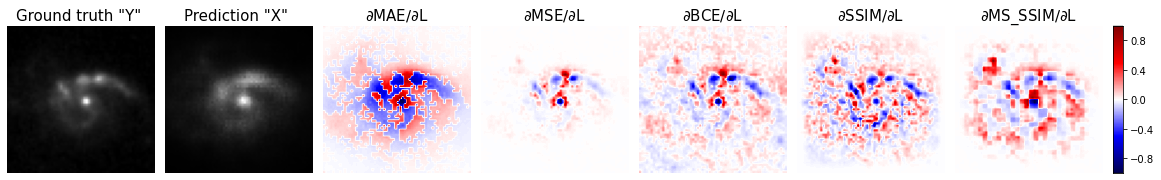

In [310]:
from mpl_toolkits.axes_grid1 import ImageGrid

im_titles=['Ground truth "Y" ','Prediction "X" ',r'$\mathrm{\partial MAE \slash \partial L}$',r'$\mathrm{\partial MSE \slash \partial L}$',\
           r'$\mathrm{\partial BCE \slash \partial L}$',\
           r'$\mathrm{\partial SSIM \slash \partial L}$',\
           r'$\mathrm{\partial MS\_SSIM \slash \partial L}$']

# Set up figure and image grid
fig = plt.figure(figsize=(20,20))

ax = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,7),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )


ax[0].imshow(norm(grad_estim_galaxy),cmap='gray')
ax[1].imshow(norm(grad_estim_galaxy_pred),cmap='gray')
im=ax[2].imshow(norm(MAE_grads),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[3].imshow(norm(MSE_grads),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[4].imshow(norm(BCE_logit_grads),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[5].imshow(norm(SSIM_grads),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[6].imshow(norm(MS_SSIM_grads),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))

for i in range(7):
  ax[i].set_title(im_titles[i],fontsize=15)
  ax[i].axis('off')

# Colorbar
ax[-1].cax.colorbar(im)
ax[-1].cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

In [294]:
grad_estim_galaxy=x_test[382:414]
grad_estim_galaxy_pred=models['vae'].predict(grad_estim_galaxy)
grad_estim_labels=y_test[382:414]

grad_estim_galaxy_pred[grad_estim_galaxy_pred>0.999]=0.999
grad_estim_galaxy_pred[grad_estim_galaxy_pred<0.001]=0.001
logit_grad_estim_galaxy_pred=np.log(grad_estim_galaxy_pred/(1-grad_estim_galaxy_pred))
logSoft_grad_estim_galaxy_pred=np.log(np.exp(grad_estim_galaxy_pred)-1)

In [295]:
BCE_logit_grads=Analysis.calculate_gradient(grad_estim_galaxy,logit_grad_estim_galaxy_pred,BCE_from_logits)

#SSIM_grads=Analysis.calculate_gradient(grad_estim_galaxy,grad_estim_galaxy_pred,SSIM_loss)
SSIM_grads=Analysis.calculate_gradient(grad_estim_galaxy,logSoft_grad_estim_galaxy_pred,SSIM_from_Deconv)

#MS_SSIM_grads=Analysis.calculate_gradient(grad_estim_galaxy,grad_estim_galaxy_pred,MS_SSIM_loss)
MS_SSIM_grads=Analysis.calculate_gradient(grad_estim_galaxy,logSoft_grad_estim_galaxy_pred,MS_SSIM_from_Deconv)

#MAE_grads=Analysis.calculate_gradient(grad_estim_galaxy,grad_estim_galaxy_pred,VAE.get_reconstruction_loss('mae'))
MAE_grads=Analysis.calculate_gradient(grad_estim_galaxy,logSoft_grad_estim_galaxy_pred,MAE_from_Deconv)

#MSE_grads=Analysis.calculate_gradient(grad_estim_galaxy,grad_estim_galaxy_pred,VAE.get_reconstruction_loss('mse'))
MSE_grads=Analysis.calculate_gradient(grad_estim_galaxy,logSoft_grad_estim_galaxy_pred,MSE_from_Deconv)


#chi_sq_grads=Analysis.calculate_gradient(grad_estim_galaxy,grad_estim_galaxy_pred,VAE.get_reconstruction_loss('chi_sq'),labels=grad_estim_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.


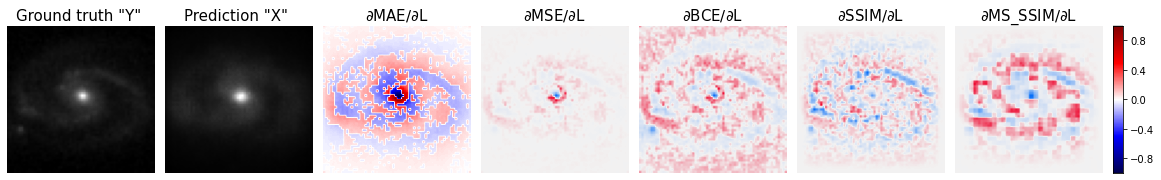

In [297]:
from mpl_toolkits.axes_grid1 import ImageGrid

im_titles=['Ground truth "Y" ','Prediction "X" ',r'$\mathrm{\partial MAE \slash \partial L}$',r'$\mathrm{\partial MSE \slash \partial L}$',\
           r'$\mathrm{\partial BCE \slash \partial L}$',\
           r'$\mathrm{\partial SSIM \slash \partial L}$',\
           r'$\mathrm{\partial MS\_SSIM \slash \partial L}$']

# Set up figure and image grid
fig = plt.figure(figsize=(20,20))

ax = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,7),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )


ax[0].imshow(norm(grad_estim_galaxy),cmap='gray')
ax[1].imshow(norm(grad_estim_galaxy_pred),cmap='gray')
im=ax[2].imshow(norm(MAE_grads),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[3].imshow(norm(MSE_grads),cmap=cmap,norm=mpl.colors.TwoSlopeNorm(0))
ax[4].imshow(norm(BCE_logit_grads),cmap=cmap,norm=mpl.colors.TwoSlopeNorm(0))
ax[5].imshow(norm(SSIM_grads),cmap=cmap,norm=mpl.colors.TwoSlopeNorm(0))
ax[6].imshow(norm(MS_SSIM_grads),cmap=cmap,norm=mpl.colors.TwoSlopeNorm(0))

for i in range(7):
  ax[i].set_title(im_titles[i],fontsize=15)
  ax[i].axis('off')

# Colorbar
ax[-1].cax.colorbar(im)
ax[-1].cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

In [299]:
q=gauss_kernel()

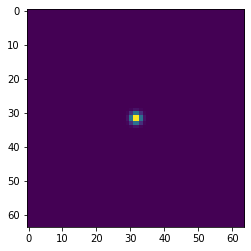

In [300]:
plt.imshow(q)

Maximal brightness 1.0


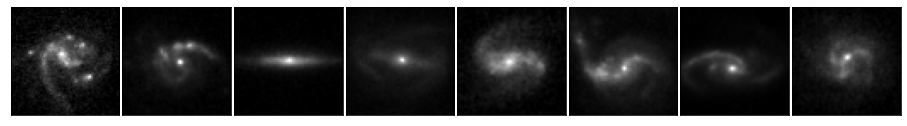

In [217]:
Analysis.plot_galaxies(imgs[:8])

In [209]:
norm(MSE_grads).max()

0.28460865068032853

In [210]:
norm(MSE_grads).min()

-1.0

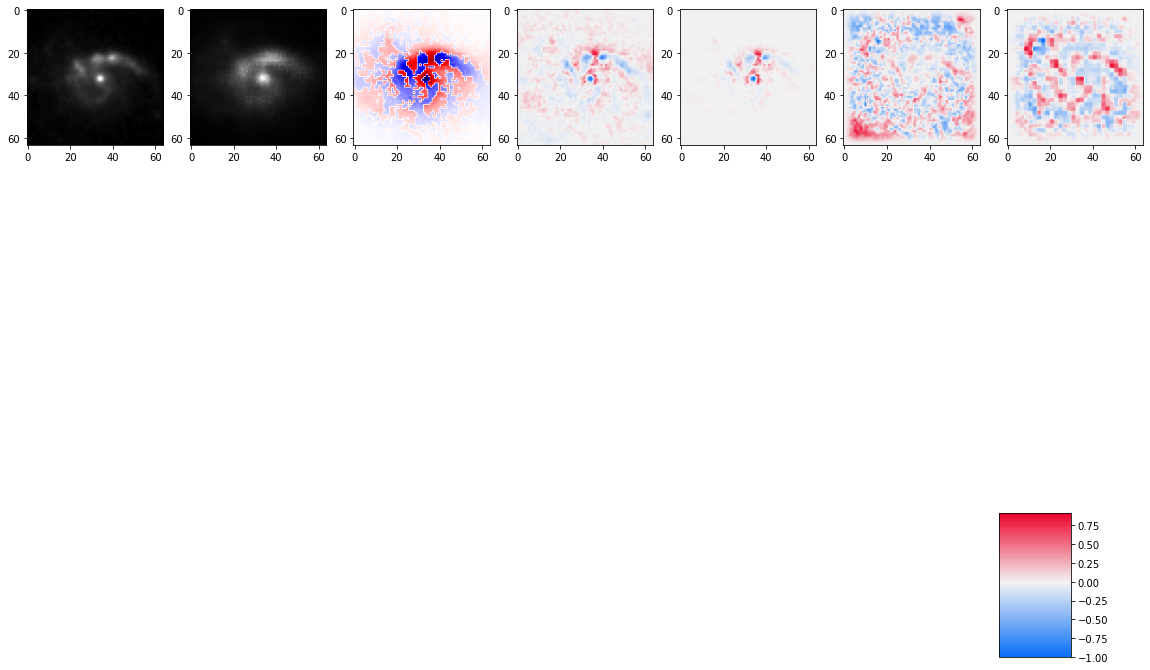

In [195]:
f, ax = plt.subplots(1, 7,figsize=(20,20))

ax[0].imshow(norm(grad_estim_galaxy),cmap='gray')
ax[1].imshow(norm(grad_estim_galaxy_pred),cmap='gray')
ax[2].imshow(norm(MAE_grads),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[3].imshow(norm(BCE_logit_grads),cmap=cmap,norm=mpl.colors.TwoSlopeNorm(0))
ax[4].imshow(norm(MSE_grads),cmap=cmap,norm=mpl.colors.TwoSlopeNorm(0))
ax[5].imshow(norm(SSIM_grads),cmap=cmap,norm=mpl.colors.TwoSlopeNorm(0))
im=ax[6].imshow(norm(MS_SSIM_grads),cmap=cmap,norm=mpl.colors.TwoSlopeNorm(0))

#f.subplots_adjust()
cbar_ax = f.add_axes([0.8, 0.1, 0.05, 0.1])
f.colorbar(im, cax=cbar_ax)

plt.show()

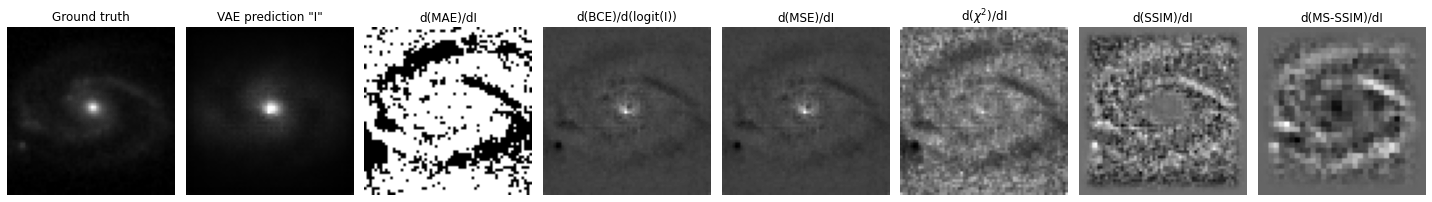

In [13]:
#grad_estim_galaxy=x_test[210]

f, ax = plt.subplots(1, 8, sharey=True,figsize=(20,20))
im_titles=['Ground truth','VAE prediction "I"','d(MAE)/dI','d(BCE)/d(logit(I))','d(MSE)/dI',r'd($\chi^2$)/dI','d(SSIM)/dI','d(MS-SSIM)/dI']
ax[0].imshow(norm(grad_estim_galaxy),cmap='gray')
ax[1].imshow(norm(grad_estim_galaxy_pred),cmap='gray')
ax[2].imshow((MAE_grads[0,:,:,0]+1)/2,cmap='gray')
ax[3].imshow(norm(BCE_logit_grads),cmap='gray')
ax[4].imshow(norm(MSE_grads),cmap='gray')
ax[5].imshow(norm(chi_sq_grads),cmap='gray')
ax[6].imshow(norm(SSIM_grads),cmap='gray')
im=ax[7].imshow(norm(MS_SSIM_grads),cmap='gray')


for i in range(8):
  ax[i].set_title(im_titles[i])
  ax[i].axis('off')
plt.tight_layout()

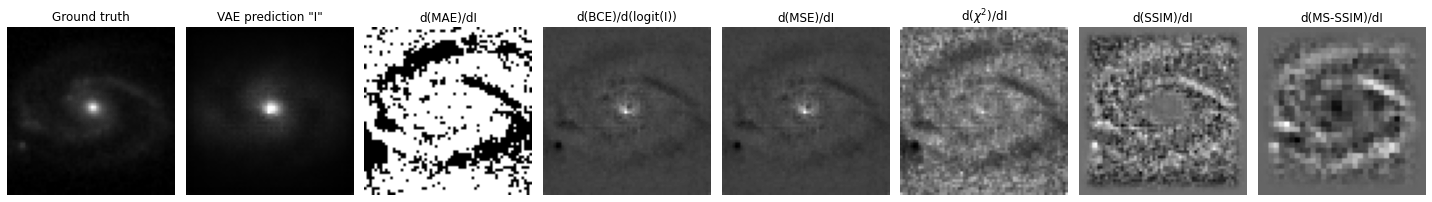

In [14]:
#grad_estim_galaxy=x_test[290]

f, ax = plt.subplots(1, 8, sharey=True,figsize=(20,20))
im_titles=['Ground truth','VAE prediction "I"','d(MAE)/dI','d(BCE)/d(logit(I))','d(MSE)/dI',r'd($\chi^2$)/dI','d(SSIM)/dI','d(MS-SSIM)/dI']
ax[0].imshow(norm(grad_estim_galaxy),cmap='gray')
ax[1].imshow(norm(grad_estim_galaxy_pred),cmap='gray')
ax[2].imshow((MAE_grads[0,:,:,0]+1)/2,cmap='gray')
ax[3].imshow(norm(BCE_logit_grads),cmap='gray')
ax[4].imshow(norm(MSE_grads),cmap='gray')
ax[5].imshow(norm(chi_sq_grads),cmap='gray')
ax[6].imshow(norm(SSIM_grads),cmap='gray')
im=ax[7].imshow(norm(MS_SSIM_grads),cmap='gray')


for i in range(8):
  ax[i].set_title(im_titles[i])
  ax[i].axis('off')
plt.tight_layout()

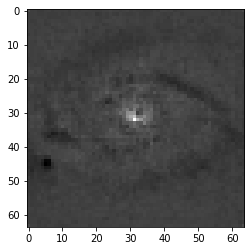

In [15]:
plt.imshow(BCE_logit_grads[0,:,:,0],cmap='gray')

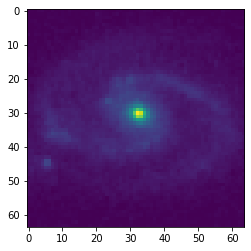

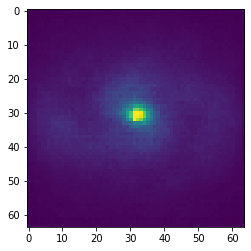

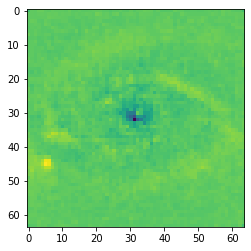

In [16]:
plt.imshow(grad_estim_galaxy[0,:,:,0])
plt.show()
plt.imshow(grad_estim_galaxy_pred[0,:,:,0])
plt.show()
plt.imshow(grad_estim_galaxy[0,:,:,0]-grad_estim_galaxy_pred[0,:,:,0])
plt.show()


# MAE

In [ ]:
beta_vae=1e-2
activation='softplus'
loss_type='mse'

models,model_loss_function,reconstruction_loss_function,regularization_loss_function=\
  VAE.get_VAE(activation,loss_type,beta_vae=beta_vae)

Checkpoint_to_load=130
Checkpoint_name='Models/MAE+Softplus/beta_vae=1e-2/'
Checkpoints_Folder=Folder+Checkpoint_name

models['vae'].load_weights(Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load))

In [ ]:
z_means=models['z_meaner'].predict(gal_dataset_images)
z_log_vars=models['z_log_varer'].predict(gal_dataset_images)
decoded=models['vae'].predict(gal_dataset_images)
std_of_mu=z_means.std(axis=0)
mean_of_var=(np.exp(z_log_vars/2)).mean(axis=0)
ratio=std_of_mu/mean_of_var

8
Maximal brightness 1.0


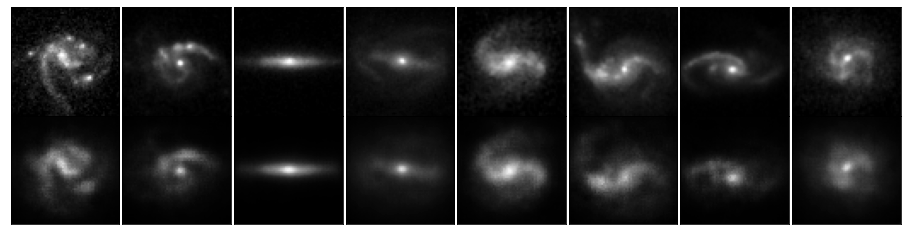

Maximal brightness 1.0


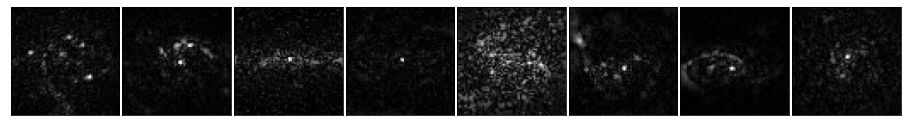

In [ ]:
Analysis.present_reconstruction(models['vae'],imgs,reconstruction_loss_function=reconstruction_loss_function,labels=labels_to_compare,grads=True)

8
Maximal brightness 1.0


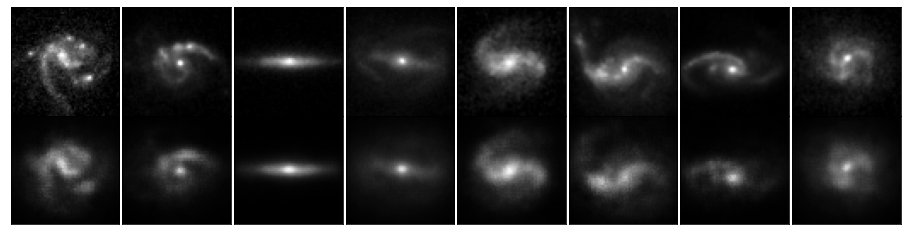

Maximal brightness 0.46618482169834863


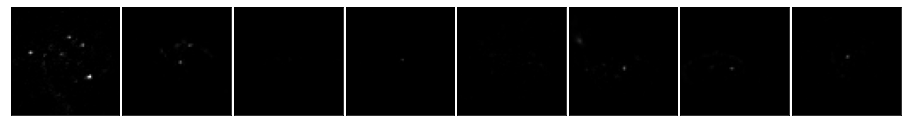

In [ ]:
Analysis.present_reconstruction(models['vae'],imgs,reconstruction_loss_function=reconstruction_loss_function,labels=labels_to_compare,resid=True)

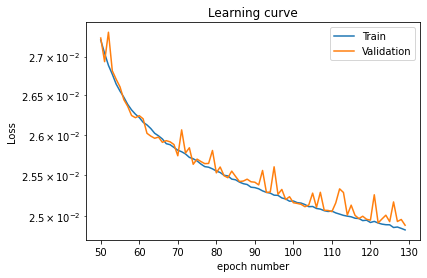

In [ ]:
Analysis.learning_curve(Checkpoints_Folder+'logs.txt',50,100000)

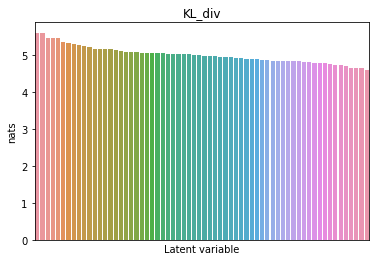

In [ ]:
DKL=Analysis.DKL_per_variable(z_means,z_log_vars)

0 130 130


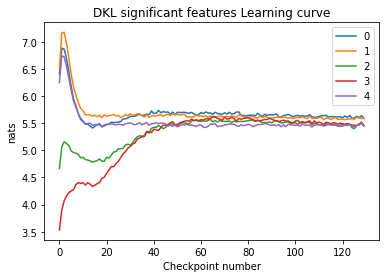

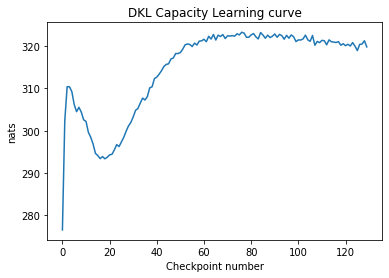

In [ ]:
Analysis.DKL_learning_curve(Checkpoints_Folder+'DKL.txt',0,100000)

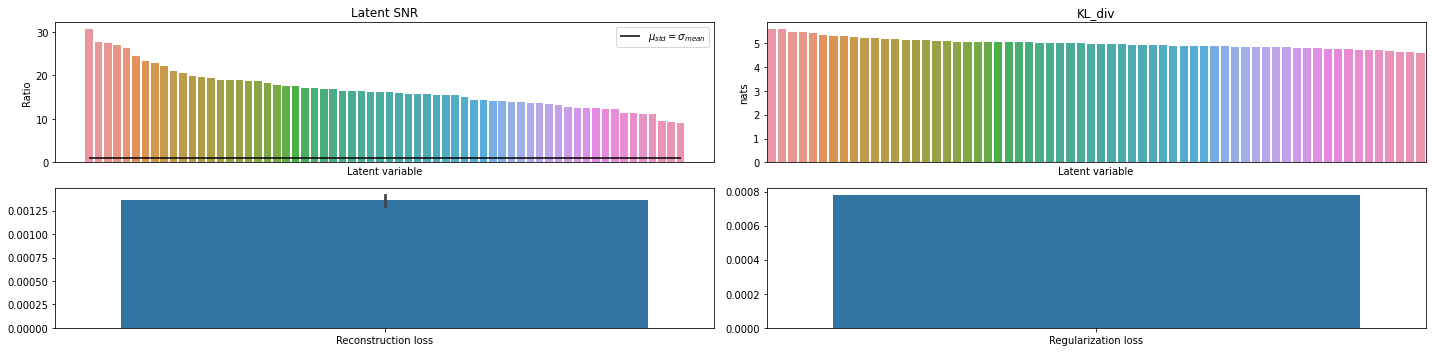

In [ ]:
Analysis.Show_latent_distr(models,x_test_labeled,reconstruction_loss_function,regularization_loss_function)

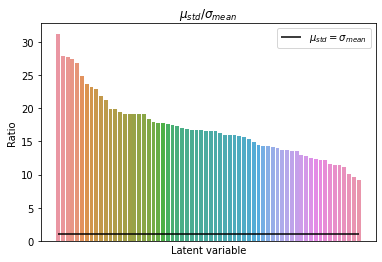

In [ ]:
Analysis.latent_relation_of_variances(ratio,sorted=True)

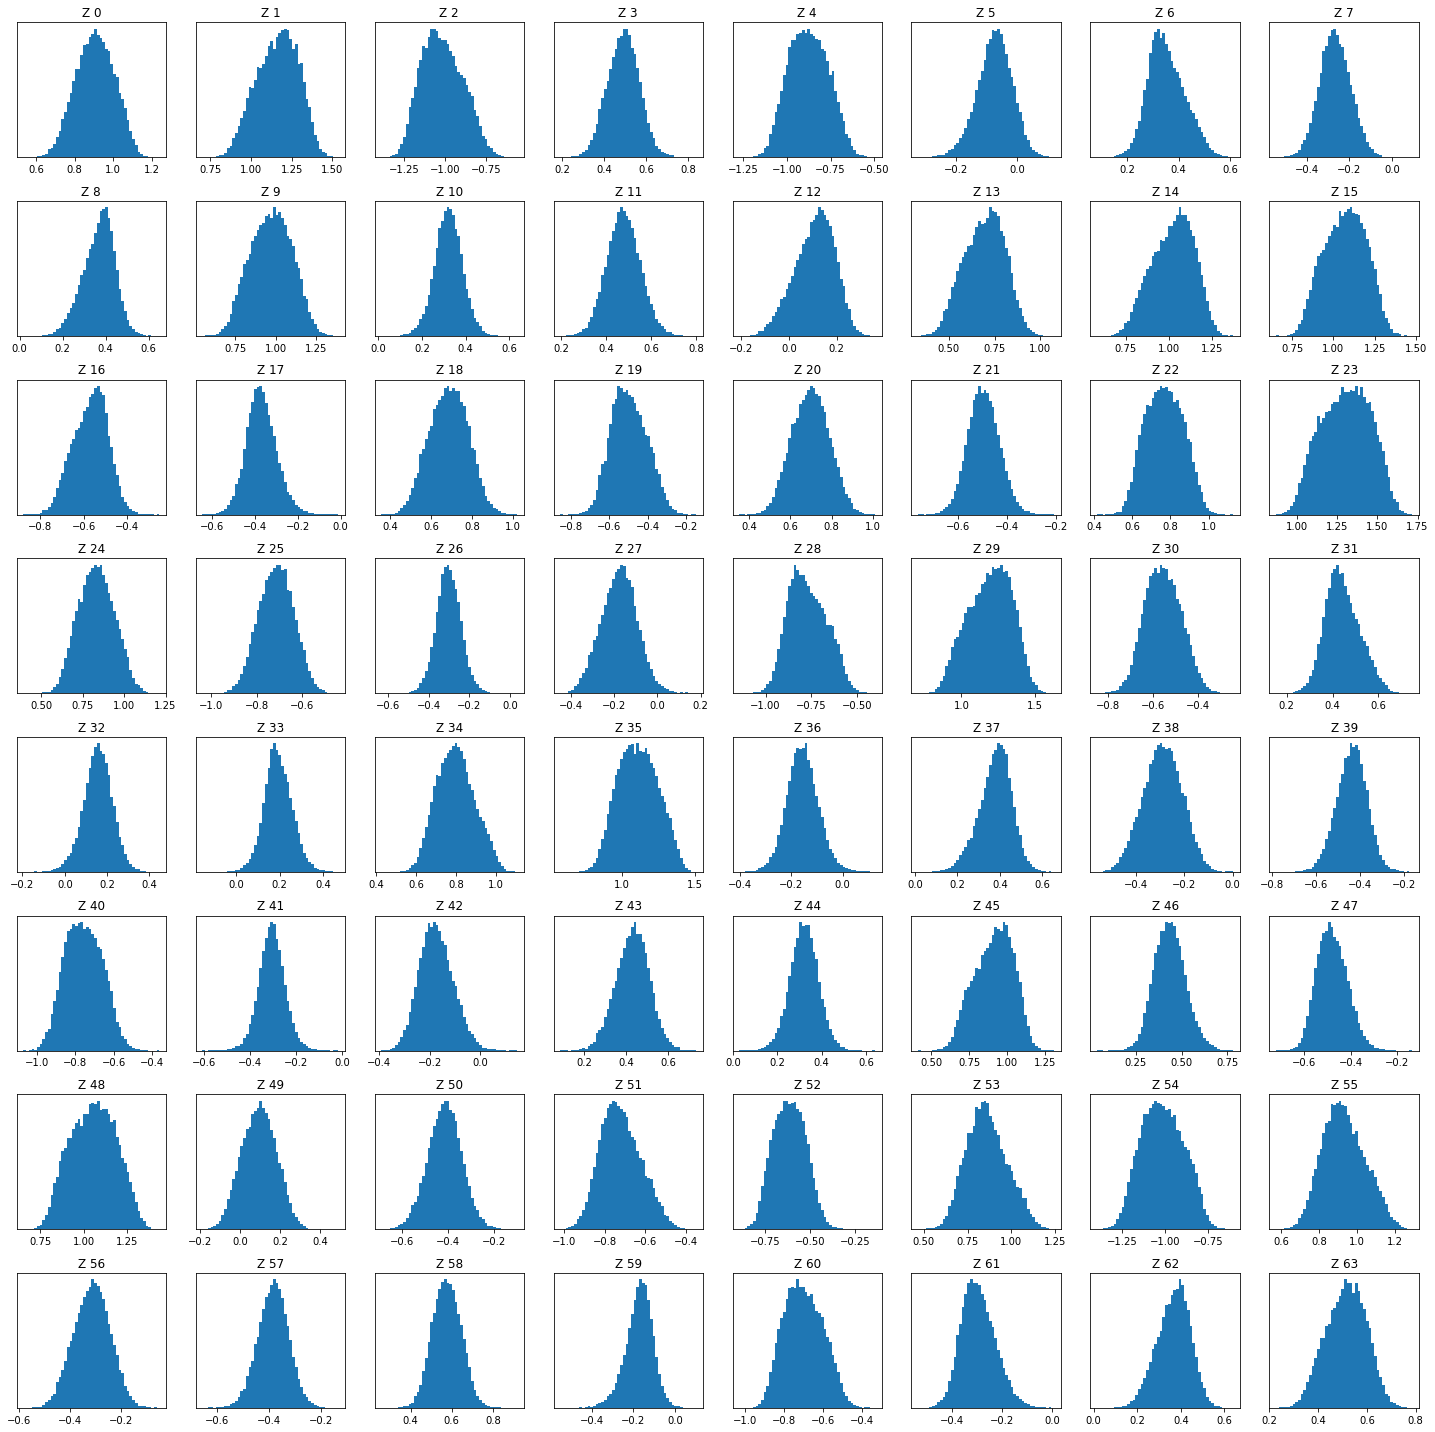

In [ ]:
Analysis.latent_distribution(z_means)

Maximal brightness 0.91163844


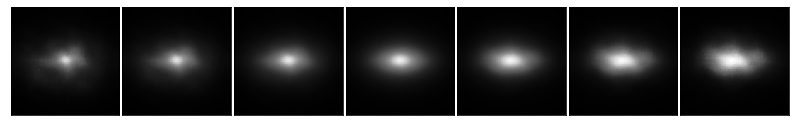

Maximal brightness 0.9292928


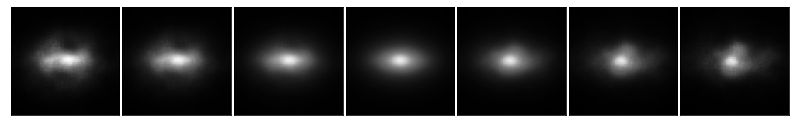

Maximal brightness 0.9219486


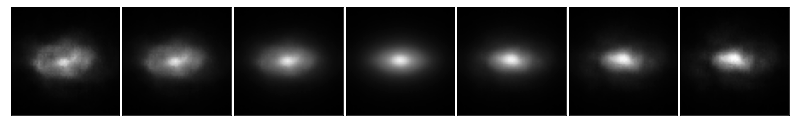

Maximal brightness 0.9083423


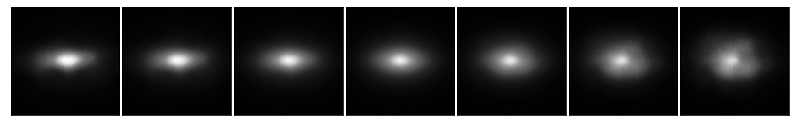

In [ ]:
Analysis.galaxy_properties_from_latent_variables(models,z_means,number_of_z_to_consider=4,dimensions='2d',sort_array=ratio)

Explained variance ratio [0.61250347 0.05627791 0.0282211  0.01566382]
Maximal brightness 0.81605


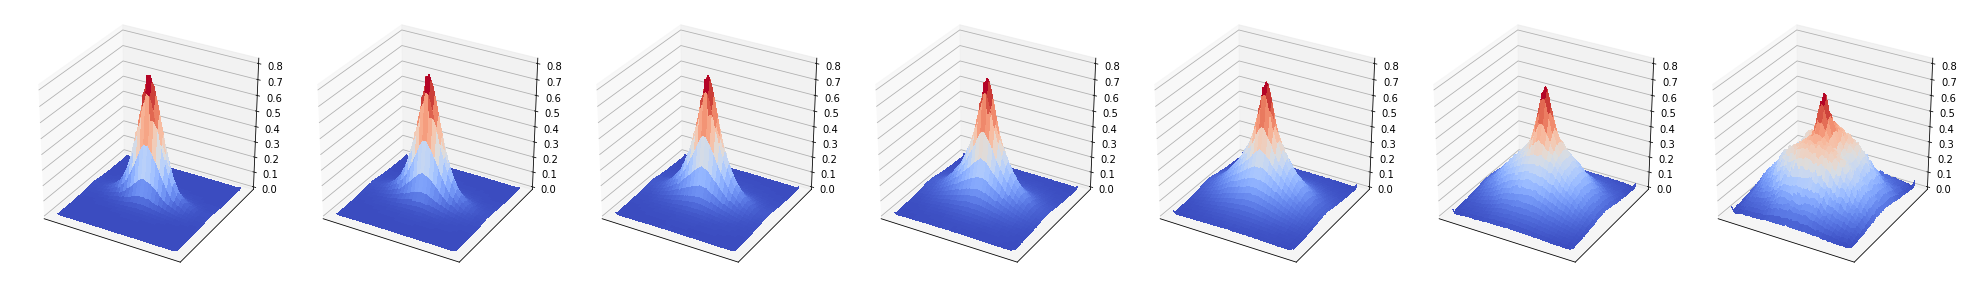

Maximal brightness 0.81711406


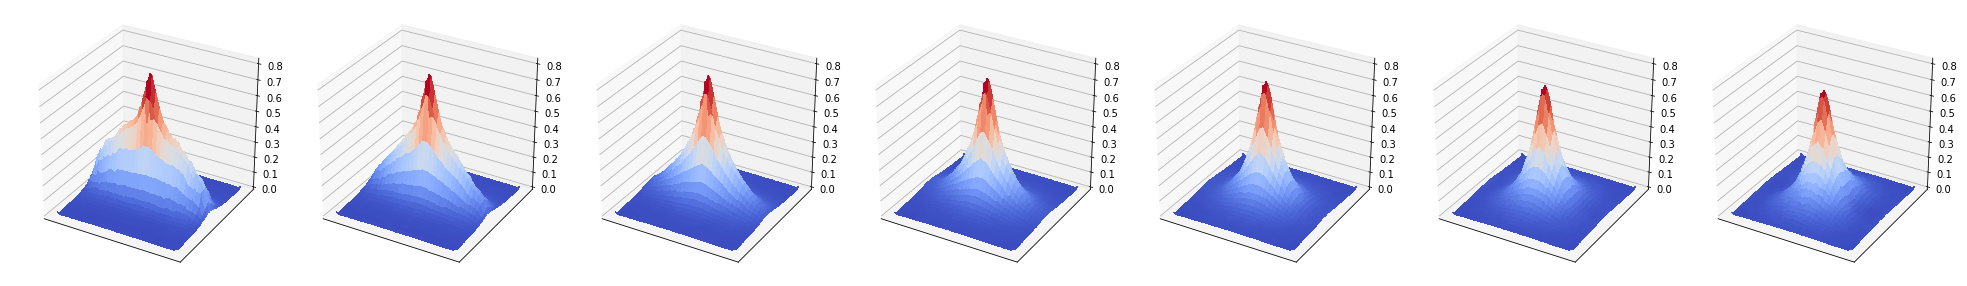

Maximal brightness 0.82953674


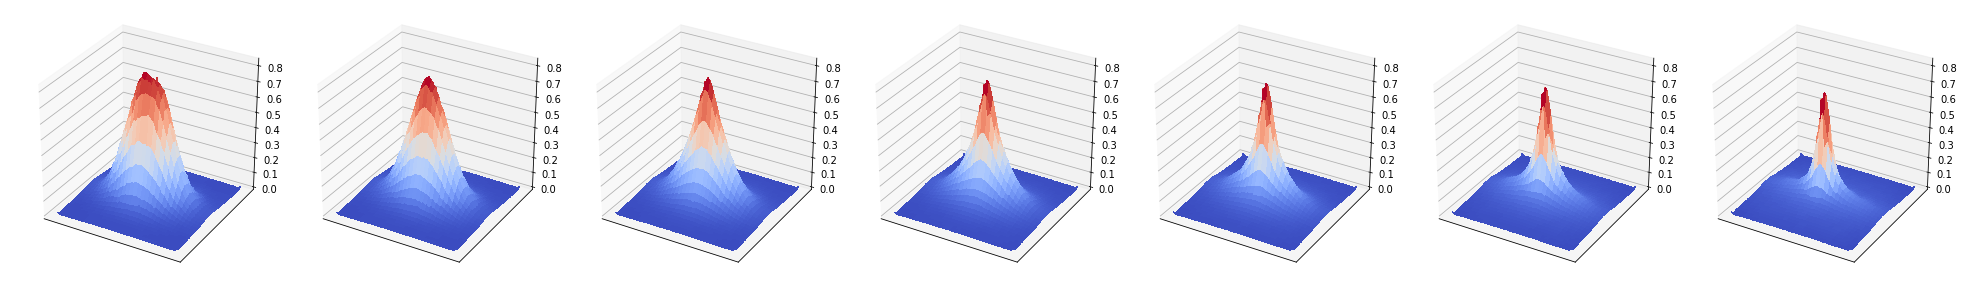

Maximal brightness 1.0310224


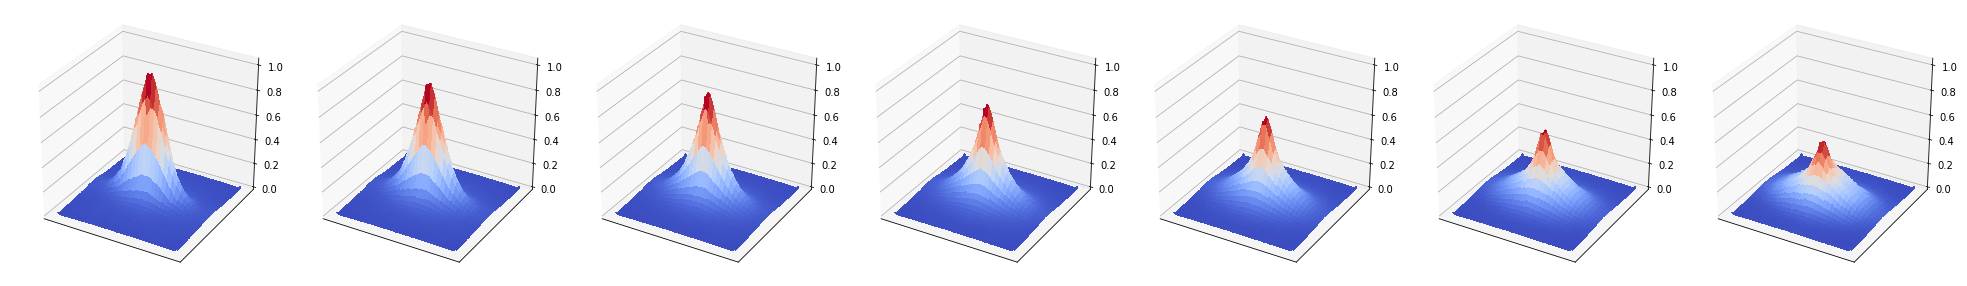

In [ ]:
Analysis.galaxy_properties_from_PCA(models,z_means,n_components=4,dimensions='3d')

Maximal brightness 1.2949389


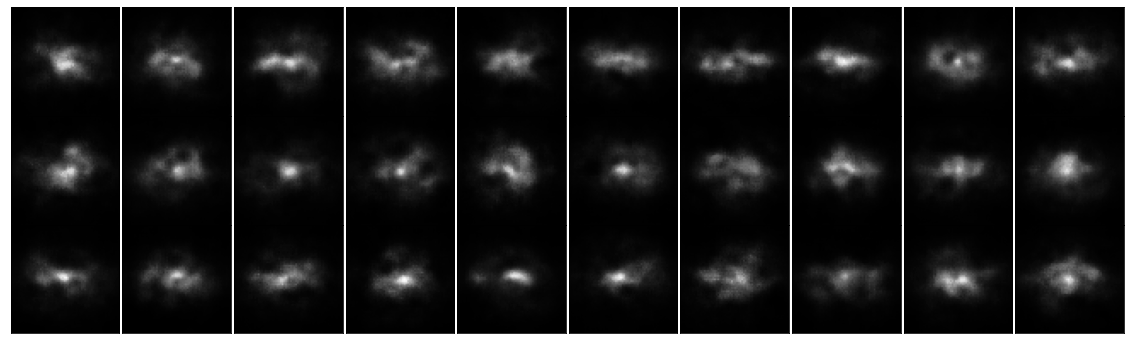

In [ ]:
Analysis.sample_random_images(models,z_means)

Maximal brightness 1.2223893


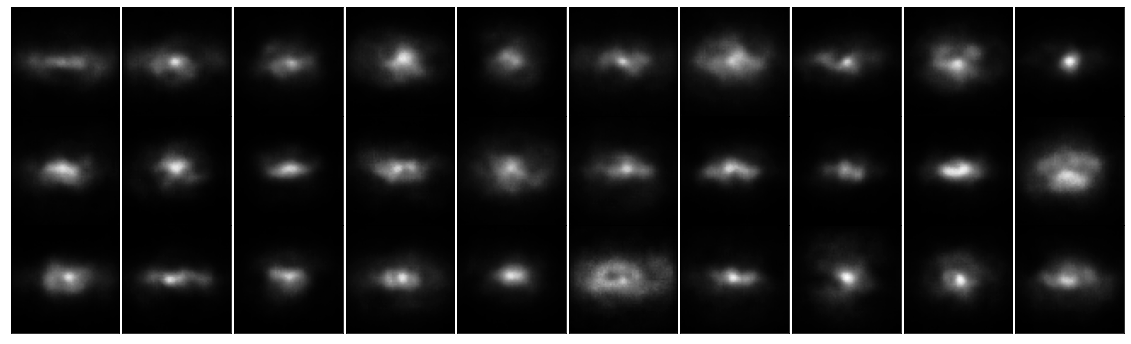

In [ ]:
Analysis.sample_random_images_PCA(models,z_means)

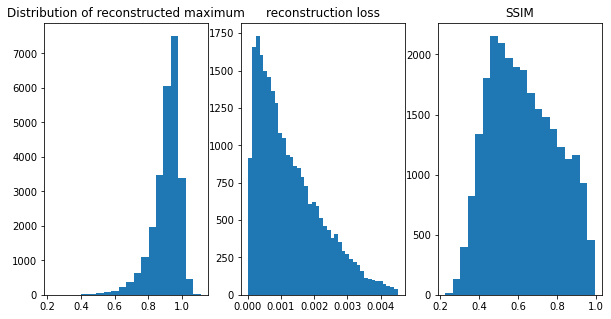

Max values RAE 0.094 ± 0.081, median 0.072
reconstruction loss values 0.001274 ± 0.000960, median 0.001031
SSIM values 0.628 ± 0.170, median 0.612


In [ ]:
Analysis.numerical_reconstruction_quality(galaxies_labeled,decoded,reconstruction_loss_function)